# Open Source Spatial Electrification Toolkit for Mini Grids (OnSSET-MG)

**OnSSET-MG** is a modified version of the Open Source Spatial Electrification Toolkit ([OnSSET](https://github.com/OnSSET)) that is dedicated to the Mini Grid design. The tool performs two key tasks: a) sizing of mini grid components and b) automated design of the distribution network in bulk.

Developed by: [SEforALL UIEP Team](https://www.seforall.org/programmes/universal-integrated-energy-plans) 

-------------------------------------------

This notebook is structured to size and designe **minigrids for multiple sites** based on solar PV, batteries and diesel. It is structure  as follows: 

1. **Importing python libraries:** This section outlines the process for importing the required Python libraries or packages needed for the analysis.

2. **Defining folders and main GIS layers:** Define the folder structure for storing and organizing data used. This includes specifying locations for downloaded datasets, processed data, and any output files

3. **Obtaining Solar Data and Temperature:** Enviromental data is retrieved from [Renewables.ninja](https://www.renewables.ninja). 

4. **Technical and economic assumptions:** This section outlines any economic and technical assumptions made during the analysis

5. **Minigrid Optimization and Distribution Grid Sizing for Clusters** This section describes the optimization process for determining the optimal hybrid generation based on the imported data and designing the distribution network
   
6. **Results:** Examples on how to export results from the model are showed

--------------------------------------

## 1. Importing python libraries required

In [1]:
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import LineString, Point, MultiLineString, Polygon, MultiPoint
from scipy.optimize import Bounds, differential_evolution
import geopandas as gpd
import os
import time

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox

We also need to import some additional functions coded by the energy modellers to:
* Optimize MG component sizing --> [Hybrids.py](./Hybrids.py)
* Automation of distribution design --> [dist_funcs.py](./dist_funcs.py)
* Bulk functions--> [Bulk.py](./Bulk.py)

In [3]:
from hybrids import *
from dist_funcs import *
from bulk import *

## 2. Defining folders and main GIS layers.

Follow the instructions to upload the main layers to size the Minigrids. To upload the layers, please provide the CRS suitable for your Area of Interest

When calculating distances it is important to choose a coordinate system that represents distances correctly in your area of interest. The coordinate system that is given below is the World Mercator, these coordinate system works well for Sub Saharan Africa but the distortions get larger as you move away from the equator.

In order to select your own coordinate system go to [epsg.io](http://epsg.io/) and type in your area of interest, this will give you a list of coordinate systems to choose from. Once you have selected your coordinate system replace the numbers below with the numbers from your coordinate system **(keep the \"EPSG\" part)**.

**NOTE** When selecting your projection (target) coordinate system make sure that you select a system with the unit of meters.

In [4]:
target_crs = 'EPSG:32615' ### For Guatemala

There are three main GIS layers needed to run OnSSET-MG: Administrative layer, buildings layer and clusters. Depending on the scope of the analysis, the administrative layer will need to be updated to sucessfully represent the region of interest. For example, this notebook focuses on sizing Minigrids for different communities of Guatemala, thus, the choosen administrative layer depicts the complete country. On the other side, the cluster layer cover the geographical area of all of the buildings to be electrified, while the buildings layer provides the geographical location of the structures. The dataset used and pre-processed in QGIS was downloaded from [VIDA](https://beta.source.coop/repositories/vida/google-microsoft-open-buildings/description/)

In [5]:
messagebox.showinfo('OnSSET-MG', 'Select the administrative layer')
admin0 = gpd.read_file(filedialog.askopenfilename(filetypes = (("vector",["*.shp", "*.gpkg", "*.geojson"]),("all files","*.*")))).to_crs(target_crs)

In [6]:
messagebox.showinfo('OnSSET-MG', 'Select the clusters for MiniGrids')
clusters = gpd.read_file(filedialog.askopenfilename(filetypes = (("vector",["*.shp", "*.gpkg", "*.geojson"]),("all files","*.*")))).to_crs(target_crs)

In [7]:
messagebox.showinfo('OnSSET-MG', 'Select the buildings layer')
buildings = gpd.read_file(filedialog.askopenfilename(filetypes = (("vector",["*.shp", "*.gpkg", "*.geojson"]),("all files","*.*")))).to_crs(target_crs)
buildings_centroids = buildings.copy()
buildings_centroids["geometry"] = buildings_centroids["geometry"].centroid

In [8]:
messagebox.showinfo('OnSSET-MG', 'Select the folder where hourly PV Data will be stored')
workspace_pv= filedialog.askdirectory()

In [9]:
messagebox.showinfo('OnSSET-MG', 'Select the folder where GIS Outputs will be stored')
workspace_gis= filedialog.askdirectory()

## 3. Obtaining Solar Data and Temperature.

The Global Horizontal Irradiation (GHI) and temperature data can be retrieved from [renewables ninja](https://www.renewables.ninja). Before proceeding, please consult the [documentation](https://www.renewables.ninja/documentation) as creating a user account and password is necessary to generate a token for downloading specific data. You can do this by following the steps below:
1. Create a free account on the Renewables.ninja [website](https://www.renewables.ninja/register). Once registered, users gain the ability to download datasets and utilize the API for programmatic data retrieval.<br>
<br>
2. Log in. To access a personal API token, navigate to the profile by clicking on the symbol in the top right corner (usually a profile picture or icon) on [profile](https://www.renewables.ninja/profile).<br>
<br>
3. Within the profile settings, users can find their unique API token. This token should be copied and pasted between quotation marks (token = 'your_token_here') when using the API in the code.

In [10]:
token = '739960d22c614703636aba78797e54ece90e8520' 

The _getting_pv_data_bulk_ function takes the following arguments: administrative division, clusters, target CRS, disk space for storing results, and a token to retrieve solar data from [renewables ninja](https://www.renewables.ninja). Internally, the function generates a grid of 49 (7x7) evenly distributed points within the rectangular bounds of the administrative division's polygon. It then filters out points that fall outside the polygon that fall outside the polygon and uses the remaining points as pivots to retrieve Global Horizontal Irradiance (GHI) and temperature data. An identifier column is added to the clusters, which is later used in the code to read from the selected PV folder the closest spatial GHI and temperature data to size the minigrid.

In [11]:
clusters, coordinates_for_data = getting_pv_data_bulk(admin0, clusters, target_crs, workspace_pv, token)

Retrieved 23 locations for hourly solar data and temperature readings from renewable.ninja in 1.4 minutes


In [12]:
single_cluster = coordinates_for_data.iloc[1].iloc[1]
latitude, longitude = single_cluster.y, single_cluster.x
hourly_ghi, hourly_temp = read_environmental_data(os.path.join(workspace_pv, 'pv_data_lat_{}_long_{}.csv'.format(latitude, longitude)))

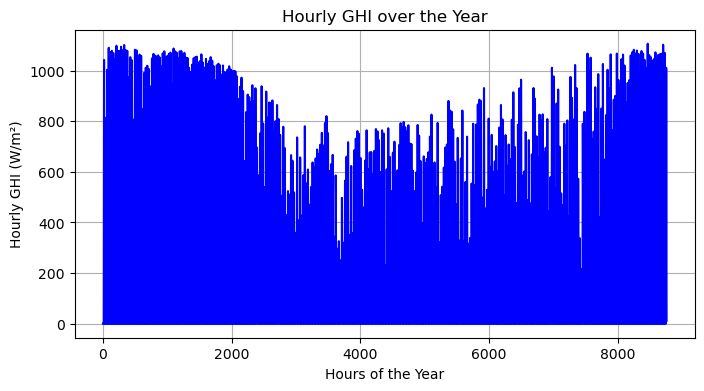

In [13]:
# Generate the array for hours of the year
hours_of_year = np.arange(8760)  # Array from 0 to 8759
# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(hours_of_year, hourly_ghi, marker='', linestyle='-', color='b')
# Labeling the axes
plt.xlabel('Hours of the Year')
plt.ylabel('Hourly GHI (W/m²)')
# Adding a title
plt.title('Hourly GHI over the Year')
# Show grid
plt.grid(True)
# Display the plot
plt.show()

## 4. Technical and economic assumptions.

### Generation

The following technical and economic parameters are used for the optimization of generation in the microgrid. Please update these values based on the specific local context of analysis to ensure accurate results. Be mindful of units, as inconsistencies can lead to unexpected outcomes.

**General parameters**

In [14]:
start_year=2024
end_year=2049
discount_rate=0.08      ##The annual rate of return expected on an investment over the project's lifetime. This value is expressed as a percentage

**Diesel generator**

In [15]:
diesel_price=0.872     ## Diesel Price (USD/liter): The cost of diesel fuel used for generator operation
diesel_cost=350        ## Diesel Generator Cost (USD/kW): The initial capital cost of purchasing and installing a diesel generator, per kilowatt of rated power
diesel_om=0.1           ## Diesel Operational and mainenance Cost (USD/kW/year): The annual cost of operating and maintaining the diesel generator, share of CAPEX
diesel_life=10         ## Diesel Generator Lifetime (years): The expected number of years the diesel generator will be operational before requiring replacement
diesel_limit=0.5       ## Diesel Limit (0-1): This value sets the maximum allowable contribution of the diesel generator to the microgrid's annual electricity generation. It is expressed as a decimal between 0 and 1

**Batteries | Storage**

In [16]:
battery_cost=400           ## Battery Capital Cost (USD/kWh): The initial capital cost of purchasing and installing a battery storage system, per kilowatt-hour of storage capacity
full_life_cycles=2000      ## Battery Lifetime (cycles): The expected number of full charge/discharge cycles the battery can undergo before reaching its end of life
battery_inverter_cost=250  ## Battery Inverter Cost (USD/kW): The initial capital cost of purchasing and installing a battery inverter, per kilowatt of power
battery_inverter_life=20   ## Battery Inverter Lifetime (years): The expected number of years the battery inverter will be operational before requiring replacement
n_chg=0.90                 ## Battery Charging Efficiency (0-1): This parameter represents the efficiency of the battery charging process, accounting for energy losses during charging cycles. It is expressed as a decimal between 0 and 1
n_dis=0.9                  ## Battery Discharging Efficiency (0-1): This parameter represents the efficiency of the battery discharging process, accounting for energy losses during discharging cycles. It is expressed as a decimal between 0 and 1
dod_max=0.9                ## Dept-of-discharge (DOD) (0-1): DOD represents the percentage of a battery's total capacity that has been discharged in a single cycle, relative to its full charge capacity. It is expressed as a decimal between 0 and 1

**Solar panels  & Inverter**

In [17]:
pv_cost=1200          ## PV Panel Cost (USD/kWp): The initial capital cost of purchasing and installing photovoltaic (PV) panels, per watt-peak (Wp) of rated power output
pv_om=0.025           ## PV O&M Cost (USD/kWp/year): The annual cost of operating and maintaining the PV system, share of CAPEX. This includes costs for cleaning, monitoring, and minor repairs
pv_inverter=175       ## PV Inverter Cost (USD/kWp): The initial capital cost of purchasing and installing a solar inverter, per kilowatt-peak (Wp) of PV installed capacity. If this cost is already included in the PV Panel Cost, set this value to 0
charge_controller=0   ## Solar Charge Controller Cost (USD/kWp): The initial capital cost of purchasing and installing a solar charge controller, per kilowatt-peak (Wp) of PV panel capacity. If this cost is already included in the PV Panel Cost, set this value to 0
pv_life=25            ## PV System Lifetime (years): The expected number of years the PV system (panels and inverter) will be operational before requiring replacement
inv_eff=0.93          ## Inverter Efficiency (0-1): This parameter represents the efficiency of the inverter, which accounts for energy losses during conversion from DC to AC

**Minigrid parameter**

Loss of Power Supply Probability (LPSP): This parameter indicates the reliability of the microgrid in supplying electricity. A lower LPSP signifies a more reliable system with a lower chance of power outages.

In [18]:
lpsp_max=0.005

### Distribution

The sizing process generates two outputs related to the distribution grid: a GeoJSON file containing detailed information about the designed grid, disaggregated by the type of line (trunk, lateral, service drop), and a point layer file for poles that specifies their spatial locations. By incorporating capital costs (installation costs) and operational costs into the analysis, it's possible to estimate the Levelized Cost of Energy (LCOE) for the entire distribution network. To calculate the LCOE, you'll need the following variables:

Cost of distribution lines (USD/km), which refers to the capital cost associated with installing one kilometer of distribution lines within the community

In [19]:
cost_grid_km = 2000     ## LV line (0.2 – 0.4 kV) | Cost of low voltage distribution (approximation) -- overhead line, ABC type 100 mm2 Aluminium

Cost of Poles (USD/Pole): which refers to the capital cost associated with installing supporting poles for distribution

In [20]:
cost_pole = 150+26+72.2+34+60     ## pole + overhead accessories + lightning protection + labour cost --> per pole
pole_dist = 50                    ## meters

Service drop | Customer connection costs

In [21]:
con_cost = 173 # overhead access. | meter | ready board+rectifier

Operational & Maintenance costs (% initial investment): The annual cost of operating and maintaining the grid as percentage of initial investment

In [22]:
grid_om = 0.05

#### Other costs

In [23]:
labour_cost =  100      ## Labour cost ~ 100 USD/kWp
trans_cost = 27         ## Transportation of material | 27 USD/connection
sga_cost = 18          ## $/connection/year ($1.5/con/month) which adds to the operation and maintenance costs

## 5. Minigrid Optimization and Distribution Grid Sizing for Clusters

The following cell performs the minigrid optimization and distribution grid sizing for the given clusters, leveraging geographic and environmental data. A summary of the main key steps are executed for each cluster:

* **Cluster Identification:** For each cluster, the script retrieves geographic data and identifies the households within the cluster's boundary. 

* **Environmental Data Loading:** Solar irradiance (GHI) and temperature data are fetched based on the cluster's centroid coordinates, which are derived from the nearest available location.

* **Energy Demand Estimation:** The demand for each cluster is calculated using demand estimation models. This approach uses empirical data to determine the number of customers and their respective load curves based on customer type (e.g., residential, commercial). The estimated load curves are used to determine the total energy demand for the cluster.

* **Energy System Optimization:** The script employs a Particle Swarm Optimization (PSO) algorithm through the optimizer_de function to find the optimal configuration of energy system components, including solar PV, battery storage, and diesel generators. The objective is to minimize the Levelized Cost of Energy (LCOE) while considering constraints like diesel fuel usage and system lifecycle costs.

* **Distribution Grid Sizing:** A distribution network is designed for each cluster by calculating the placement of poles, trunk lines, service lines, and secondary lines. These elements are used to connect households to the central mini-grid, and their associated costs are estimated, including the cost of grid installation and maintenance.

* **Cost and LCOE Estimation:** Both capital expenditures (CAPEX) and operational expenditures (OPEX) are calculated for energy generation and grid infrastructure. The total costs are used to compute the LCOE for both energy generation and distribution over the system's lifetime.

* **Results:** The final output for each cluster includes optimized energy system parameters, distribution network details, CAPEX, OPEX, and LCOE values. That could be exported in .gpkg format. The time taken for optimization and grid sizing is also recorded.

In [24]:
new_clusters = gpd.GeoDataFrame(geometry=[], crs=target_crs)
grid = gpd.GeoDataFrame(geometry=[], crs=target_crs)
poles = gpd.GeoDataFrame(geometry=[], crs=target_crs)
service_gdf = gpd.GeoDataFrame(geometry=[], crs=target_crs)
secondary_gdf = gpd.GeoDataFrame(geometry=[], crs=target_crs)
trunks_gdf = gpd.GeoDataFrame(geometry=[], crs=target_crs)


for idx in clusters.index:

    try:
    
        row = clusters.loc[idx]
        # row is a Series, convert it to a GeoDataFrame if needed
        
        row_gdf = gpd.GeoDataFrame([row], columns=clusters.columns, crs=clusters.crs)
        # Now row_gdf is a GeoDataFrame with a single row
    
        # Clip households based on the current site's geometry
        households_in_cluster = gpd.clip(buildings_centroids, row_gdf)
        
        # Fetch the corresponding coordinates for the cluster centroid
        coordinates_cluster = coordinates_for_data[coordinates_for_data ['id'] == row['identifier']]
        
        # Extract latitude and longitude for environmental data retrieval
        latitude, longitude = coordinates_cluster.geometry.y.iloc[0], coordinates_cluster.geometry.x.iloc[0]
        
        # Load environmental data for this specific site
        pv_data_path = os.path.join(workspace_pv, f'pv_data_lat_{latitude}_long_{longitude}.csv')
        hourly_ghi, hourly_temp = read_environmental_data(pv_data_path)
        
        # Estimate demand and optimize for this site
        row_gdf, annual_demand, load_curve = estimating_annual_demand_by_bundles(row_gdf, households_in_cluster)       
        
        # Perform optimization for the specific site
        start_time_opt = time.time()
        ret = optimizer_de(
            diesel_price=diesel_price, hourly_ghi=hourly_ghi, hourly_temp=hourly_temp, 
            load_curve=load_curve, start_year=start_year, end_year=end_year, discount_rate=discount_rate, 
            diesel_cost=diesel_cost, battery_cost=battery_cost, full_life_cycles=full_life_cycles, 
            battery_inverter_cost=battery_inverter_cost, pv_cost=pv_cost, pv_inverter=pv_inverter, 
            charge_controller=charge_controller, diesel_limit=diesel_limit, lpsp_max=lpsp_max, inv_eff=inv_eff, 
            n_chg=n_chg, n_dis=n_dis, dod_max=dod_max, pv_om=pv_om, diesel_om=diesel_om, 
            battery_inverter_life=battery_inverter_life, pv_life=pv_life, diesel_life=diesel_life
        )
        end_time_opt = time.time()

        #Perform sizing of distribution network for the specific site
        start_time_dist = time.time()
        trunk_lines = create_trunk_line(row_gdf.geometry.iloc[0], spacing=pole_dist, plot=False)
        trunk_lines, intersects = simplify_trunk_lines(trunk_lines, length_removal=200, split_distance=750, plot=False)
        trunk_lines_gdf = gpd.GeoDataFrame(geometry=trunk_lines)
        voronois = voronoi_areas(trunk_lines_gdf, row.geometry, plot=False)
        grid_row, poles_gdf_row, service_gdf_row, secondary_gdf_row, trunks_gdf_row=\
        creating_grid(trunk_lines, voronois, row_gdf["id"], households_in_cluster, target_crs)
        end_time_dist = time.time()
        
        #Estimating cost of distribution based on results and Non-GIS information
        cost_grid = cost_grid_km * (sum(trunks_gdf_row["Length"])/1000 +\
                                    sum(secondary_gdf_row["Length"])/1000) #total cost of main grid and laterals per cluster
        cost_service_drops = con_cost*(sum(service_gdf_row['Length'])/1000) #total cost of service drops per settlement
        total_cost_poles = cost_pole * poles_gdf_row["No. Poles"].values[0] #Total cost of installing poles
        total_cost_grid = cost_grid + cost_service_drops + total_cost_poles #Total CAPEX for distribution costs
        total_om_grid = grid_om * total_cost_grid
        
        #Calculating LCOE for distribution
        lcoe_distribution = calculate_distribution_lcoe(end_year=end_year, 
                            start_year=start_year, 
                            annual_demand=annual_demand, 
                            distribution_cost=total_cost_grid, 
                            om_costs=total_om_grid, 
                            distribution_life=30, 
                            discount_rate=discount_rate)
        
        #Estimating other costs
        total_cost_labour = round(ret["best_solution"][0],1) * labour_cost #Total Labour Costs per cluster
        
        project_life = end_year - start_year
        total_cost_sga = sga_cost*len(households_in_cluster)
        total_sga = 0
        for year in range(project_life):
            total_sga += total_cost_sga / ((1 + discount_rate) ** year) #total SGA costs per cluster

        transportation_costs = trans_cost*len(households_in_cluster) #Total SGA costs per cluster

        #Basic information for the Minigrid
        row_gdf.loc[:, "LCOEg [USD/kWh]"] = round(ret["lcoe"], 3)
        row_gdf.loc[:, "PV Cap [kWp]"] = round(ret["best_solution"][0],1)
        row_gdf.loc[:, "Battery Cap [kWh]"] =round(ret["best_solution"][1],1)
        row_gdf.loc[:, "Diesel Cap [kW]"] =round(ret["best_solution"][2],1)
        row_gdf.loc[:, "Annual Diesel Fuel Usage [litre]"] =round(ret["best_solution"][2],1)
        
        #Basic information for the distribution grid
        row_gdf.loc[:, "LCOEd [USD/kWh]"] = round(lcoe_distribution[0],3) #lcoe_distribution
        row_gdf.loc[:, "Trunk Line [km]"] = round(sum(trunks_gdf_row["Length"])/1000,1) #kilometers_grid_main_line
        row_gdf.loc[:, "Laterals [km]"] = round(sum(secondary_gdf_row["Length"])/1000,1) #kilometers_grid_secondary_lines
        row_gdf.loc[:, "Service lines [km]"] = round(sum(service_gdf_row["Length"])/1000,1)#kilometers_services_drops
        row_gdf.loc[:, "No Poles"] =  poles_gdf_row["No. Poles"].values[0], #Number of poles

        #CAPEX Data
        row_gdf.loc[:, "CAPEX generation [USD]"] = round(ret["additional_values"][2],3)
        row_gdf.loc[:, "CAPEX Distribution [USD]"] = round(total_cost_grid,0)
        row_gdf.loc[:, "Cost of Labour [USD]"] = total_cost_labour
        row_gdf.loc[:, "Cost of Transport [USD]"] = transportation_costs
        row_gdf.loc[:, "Total CAPEX [USD]"] = round(total_cost_grid,0) + math.ceil(round(ret["additional_values"][2],3)) \
                        + total_cost_labour + transportation_costs
        
        #OPEX Data
        row_gdf.loc[:, "OPEX Generation [USD]"] =  round(ret["additional_values"][4],0) + round(ret["additional_values"][3],0) #Total OPEX Generation
        row_gdf.loc[:, "OPEX Distribution [USD]"] = round(lcoe_distribution[2],0), #Total OPEX Distribution
        row_gdf.loc[:, "OPEX SG&A [USD]"] =  round(total_sga, 0)
        row_gdf.loc[:, "Total OPEX [USD]"] = round(ret["additional_values"][4] + \
                                                   ret["additional_values"][3] + lcoe_distribution[2] + total_sga, 0), #Total OPEX
        row_gdf.loc[:, "Annual OPEX [USD]"] = round(ret["additional_values"][-1] + lcoe_distribution[-1] + total_cost_sga, 0)

        row_gdf.loc[:, "NPC [USD]"] = round(ret["additional_values"][9] + lcoe_distribution[3] \
                                            + total_sga + total_cost_labour + transportation_costs, 0) # Net Present Costs
        row_gdf.loc[:, "LCOEt [USD/kWh]"] = round(ret["lcoe"],3) + round(lcoe_distribution[0],3), #lcoe_generation + lcoe_distribution

       #Including computational times per setteltment
        row_gdf.loc[:, "Time opt (min)"] = round((end_time_opt-start_time_opt)/60,2)
        row_gdf.loc[:, "Time dist (min)"] = round((end_time_dist-start_time_dist)/60,2)
       
    
        new_clusters=pd.concat([new_clusters, row_gdf])
        grid=pd.concat([grid, grid_row])
        poles=pd.concat([poles, poles_gdf_row])
        service_gdf=pd.concat([service_gdf, service_gdf_row])
        secondary_gdf=pd.concat([secondary_gdf, secondary_gdf_row])
        trunks_gdf=pd.concat([trunks_gdf, trunks_gdf_row])

        print(f"""Optimisation and sizing of the distribution grid for cluster with ID {idx} successfully done in {round((end_time_opt - start_time_opt + end_time_dist - start_time_dist) / 60, 2)} minutes""")



    except Exception as e:
        # Log the error with details
        error_info = {
            'index': row_gdf.id,
            'error': str(e)
        }
        print(f"Error processing cluster with ID {idx}: {e}")

Optimisation and sizing of the distribution grid for cluster with ID 0 successfully done in 0.15 minutes
Optimisation and sizing of the distribution grid for cluster with ID 1 successfully done in 0.11 minutes
Optimisation and sizing of the distribution grid for cluster with ID 2 successfully done in 0.19 minutes
Optimisation and sizing of the distribution grid for cluster with ID 3 successfully done in 0.68 minutes
Optimisation and sizing of the distribution grid for cluster with ID 4 successfully done in 0.72 minutes
Optimisation and sizing of the distribution grid for cluster with ID 5 successfully done in 0.45 minutes
Optimisation and sizing of the distribution grid for cluster with ID 6 successfully done in 0.83 minutes
Optimisation and sizing of the distribution grid for cluster with ID 7 successfully done in 1.42 minutes
Optimisation and sizing of the distribution grid for cluster with ID 8 successfully done in 1.56 minutes
Optimisation and sizing of the distribution grid for cl

## 6. Results

An output file is created, and the results are progressively added before being exported to the specified folder. The results include optimized energy system configurations, distribution grid sizing details, as well as associated costs like CAPEX, OPEX, and the Levelized Cost of Energy (LCOE).

In [25]:
output_gpkg = "Results.gpkg"

In [26]:
# Export each GeoDataFrame to a separate layer in the GeoPackage
new_clusters.to_file(os.path.join(workspace_gis,output_gpkg), layer='clusters', driver="GPKG")
grid.to_file(os.path.join(workspace_gis,output_gpkg), layer='grid', driver="GPKG")
poles.to_file(os.path.join(workspace_gis,output_gpkg), layer='poles', driver="GPKG")

Visualizing some of the results:

In [27]:
row_gdf.T

,9
id,10
COMUNIDAD,CASERÍO SISBILÁ
ÁREA,None
Area_m2,1691184.82
NUMPOINTS,1150.0
geometry,MULTIPOLYGON (((833411.8011177604 1747943.9465...
identifier,36
<20 m2,173
20-50 m2,336
50-150 m2,517


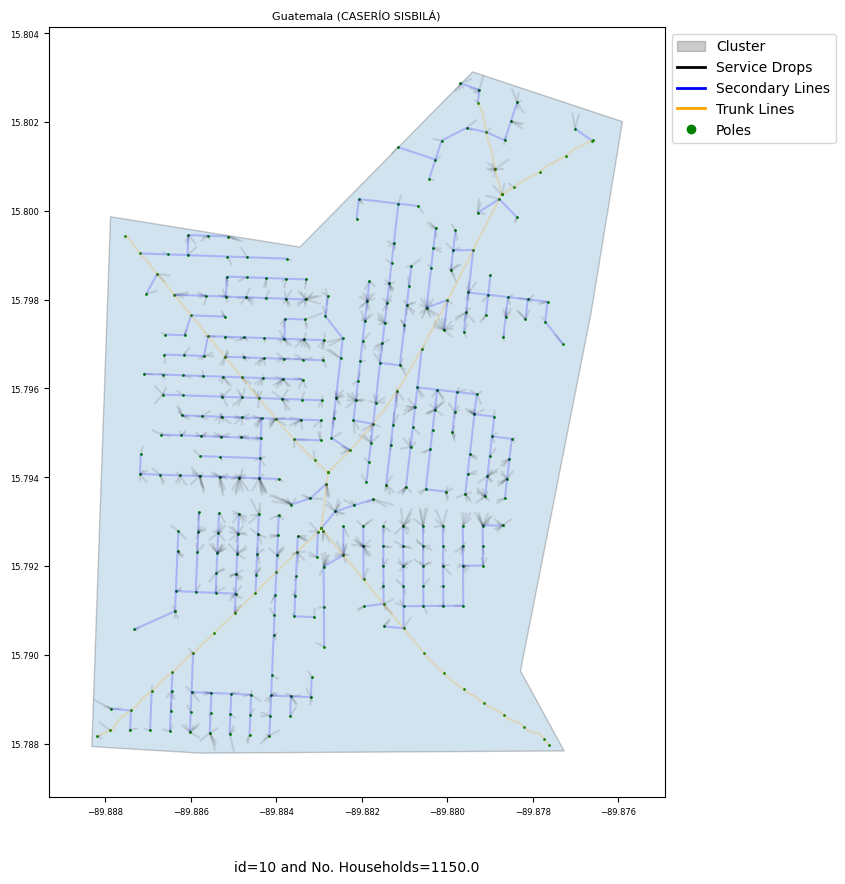

In [28]:
fig = plotting_jpeg_new("Guatemala", "CASERÍO SISBILÁ", row_gdf.id.values[0],row_gdf.NUMPOINTS.values[0], 
                    row_gdf, service_gdf_row, secondary_gdf_row, trunks_gdf_row, poles_gdf_row, households_in_cluster)